# Прогнозирование поведения акций

## 1. Подключение зависимостей 

In [1]:
import math 
import pandas_datareader as web 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError, CosineSimilarity, LogCoshError
import matplotlib.pyplot as plt
from yahooquery import Ticker

ticket = 'CNK'

## 2. Получение обучающей выборки 

In [2]:
ticker = Ticker(ticket, asynchronous=True)
df = ticker.history(period='5d', interval='1m')

df = df.droplevel(0)
df

,open,low,high,volume,close
date,,,,,
2021-01-11 09:30:00,17.070000,16.969999,17.120001,133723.0,17.049999
2021-01-11 09:31:00,17.084999,17.084999,17.260000,10039.0,17.260000
2021-01-11 09:32:00,17.260000,17.094999,17.268999,12762.0,17.120001
2021-01-11 09:33:00,17.139999,17.049999,17.200001,18687.0,17.080000
2021-01-11 09:34:00,17.080000,17.059999,17.150000,16404.0,17.070000
...,...,...,...,...,...
2021-01-15 15:55:00,19.025000,19.020000,19.058901,33166.0,19.049999
2021-01-15 15:56:00,19.045000,19.014999,19.059999,40641.0,19.030001
2021-01-15 15:57:00,19.030001,19.010000,19.040001,23747.0,19.035000


## 3. Построение графика зависимости цены акции от времени 

In [3]:
plt.figure(figsize=(16, 8), dpi=800)
plt.title('Close price history')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD', fontsize=16)
plt.tight_layout()
plt.grid()
plt.show()

## 4. Формирование выборки

In [4]:
data = df.filter(['close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .9)

training_data_len

1755

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.07573381],
       [0.1406491 ],
       [0.09737264],
       ...,
       [0.68933512],
       [0.69706298],
       [0.71251928]])

## 5. Формирование тестовой выборки

In [6]:
train_data = scaled_data[0:training_data_len:]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [7]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],  1))
x_train.shape

(1695, 60, 1)

## 6. Обучение модели 

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[LogCoshError(), RootMeanSquaredError(), MeanAbsoluteError(), CosineSimilarity()])

In [11]:
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
1695/1695 [==============================] - 26s 15ms/step - loss: 0.0023 - logcosh: 0.0011 - root_mean_squared_error: 0.0478 - mean_absolute_error: 0.0287 - cosine_similarity: 0.9900
Epoch 2/5
1695/1695 [==============================] - 25s 15ms/step - loss: 0.0011 - logcosh: 5.5072e-04 - root_mean_squared_error: 0.0332 - mean_absolute_error: 0.0230 - cosine_similarity: 0.9782
Epoch 3/5
1695/1695 [==============================] - 25s 15ms/step - loss: 6.0708e-04 - logcosh: 3.0302e-04 - root_mean_squared_error: 0.0246 - mean_absolute_error: 0.0163 - cosine_similarity: 0.9876
Epoch 4/5
1695/1695 [==============================] - 25s 15ms/step - loss: 5.3011e-04 - logcosh: 2.6455e-04 - root_mean_squared_error: 0.0230 - mean_absolute_error: 0.0155 - cosine_similarity: 0.9853
Epoch 5/5
1695/1695 [==============================] - 25s 15ms/step - loss: 4.0331e-04 - logcosh: 2.0134e-04 - root_mean_squared_error: 0.0201 - mean_absolute_error: 0.0137 - cosine_similarity: 0.9876


In [12]:
[print(metric.name, metric.total.numpy()) for metric in model.metrics]
print(model.summary())

loss 0.6836134
logcosh 0.3412779
root_mean_squared_error 0.6836134
mean_absolute_error 23.189232
cosine_similarity 1674.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
None


## 7. Формирование тестовой выборки и тестирование модели

In [13]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [14]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

## 8. Расчет среднеквадратичной ошибки

In [16]:
rmse = np.sqrt(np.mean([(p - y)**2 for p, y in zip(predictions, y_test)]))
print(f'rmse = {rmse}')
mse = np.mean([(p - y)**2 for p, y in zip(predictions, y_test)])
print(f'mse = {mse}')

rmse = 0.033442774455320734
mse = 0.001118419163269453


## 9. Построение графика предсказаний

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


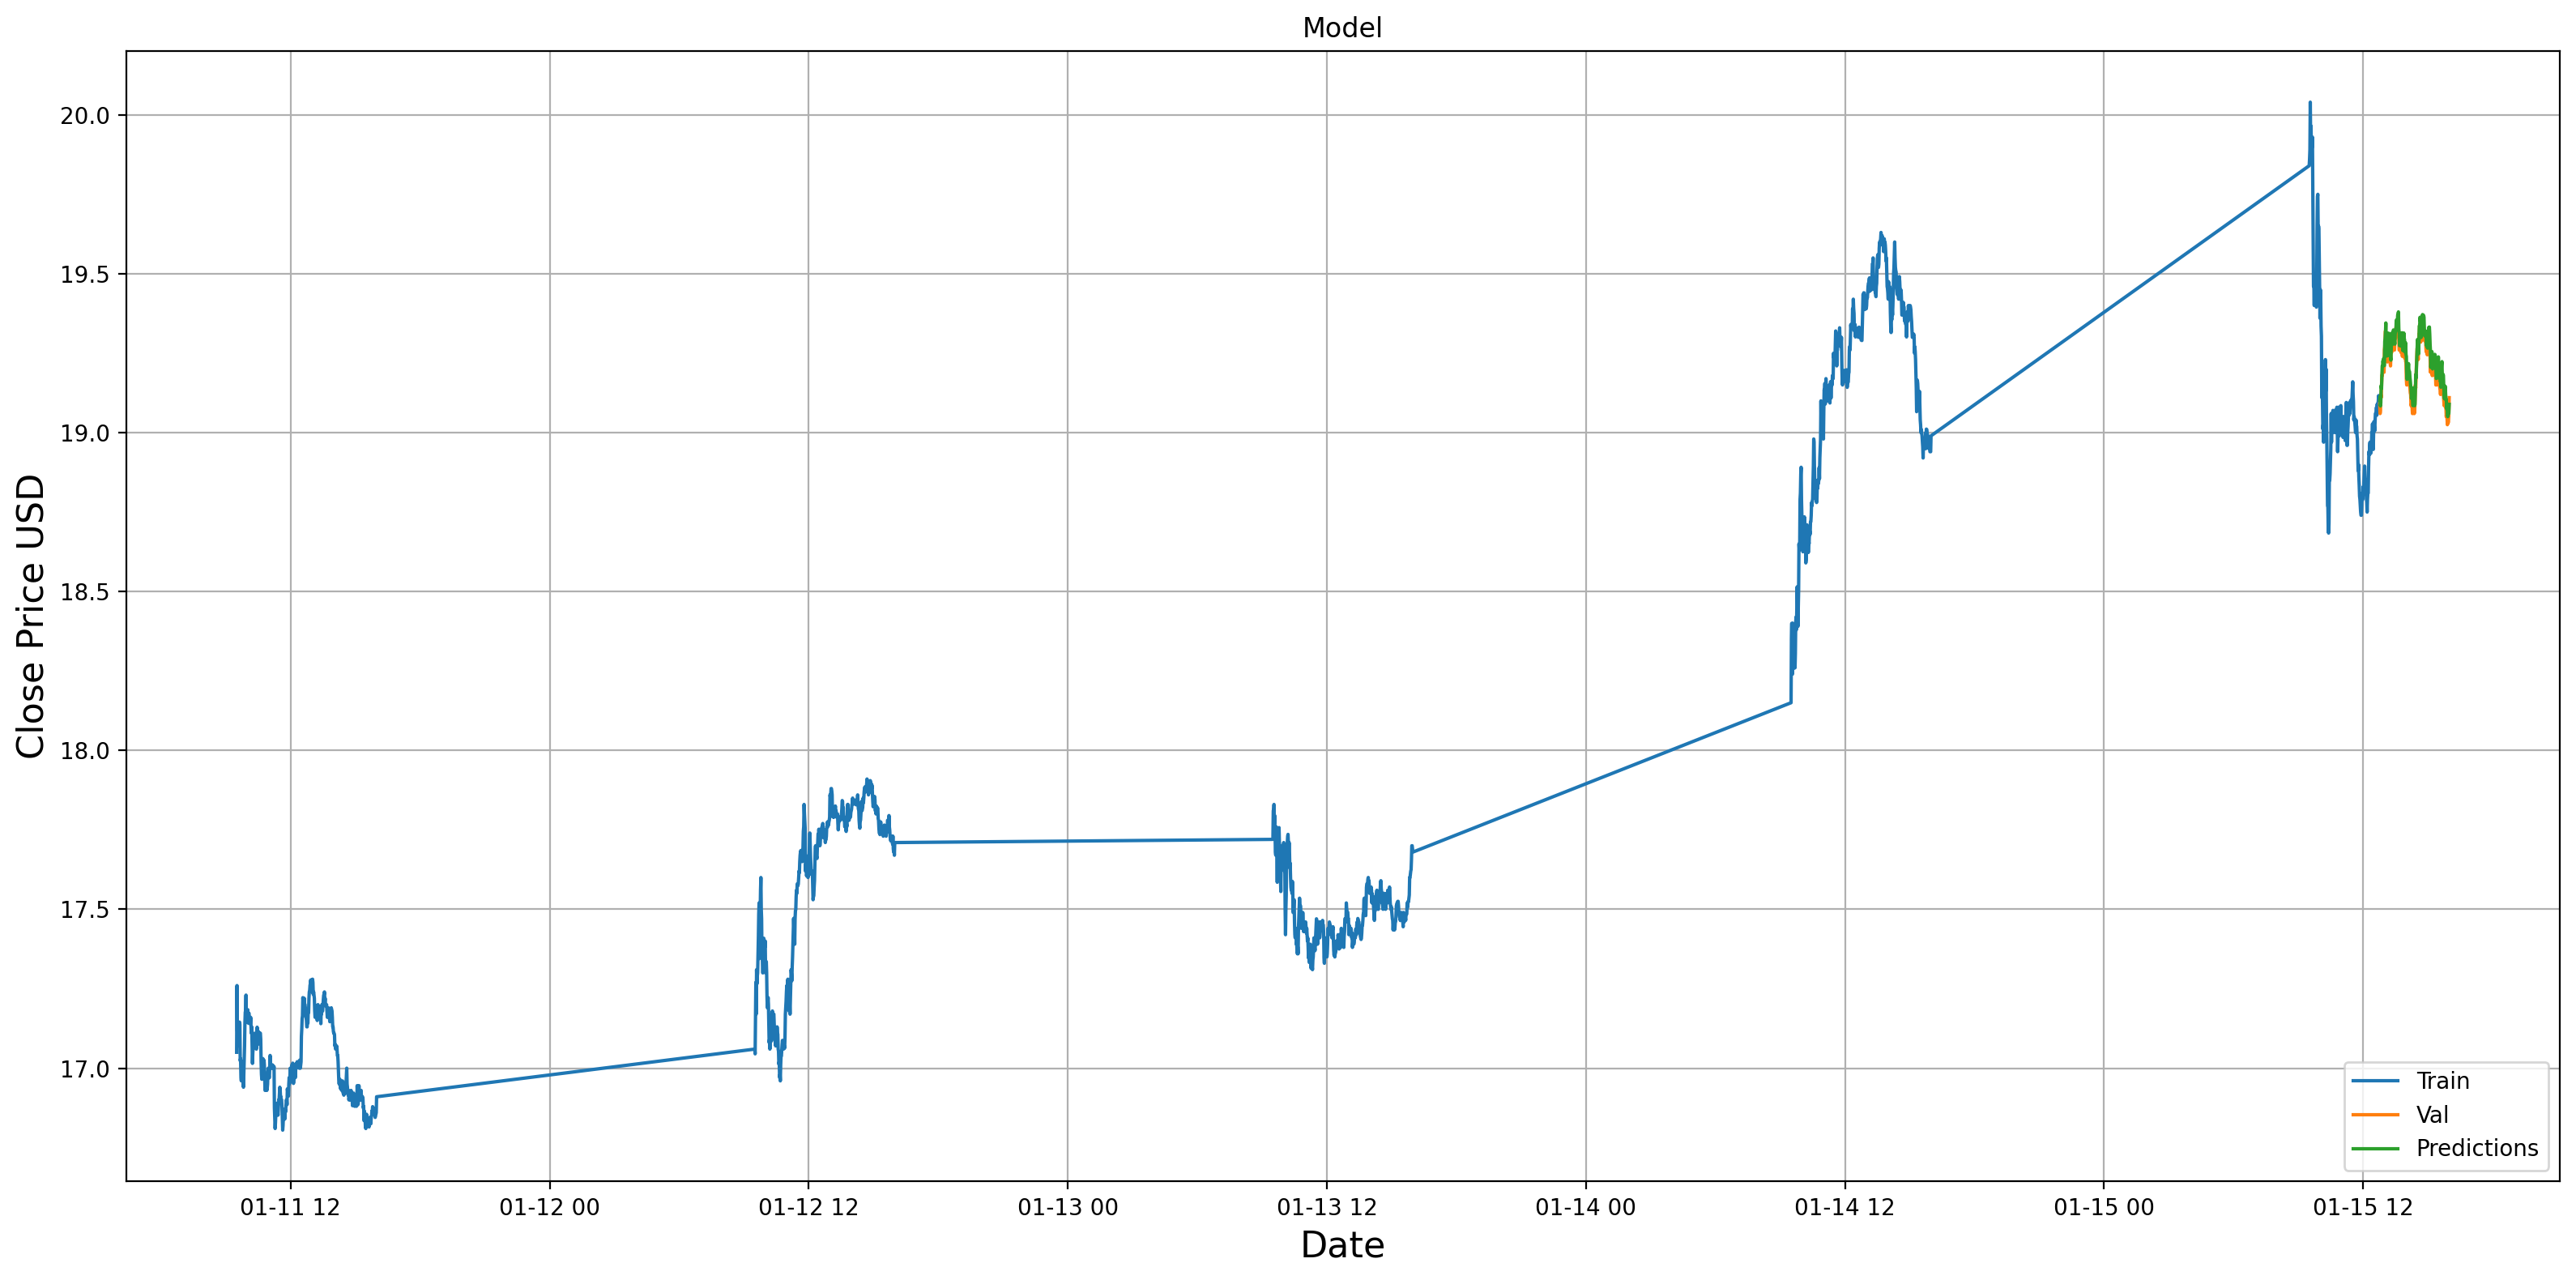

In [19]:
train = data[:training_data_len]
valid = data[training_data_len:]

valid['Predictions'] = predictions
plt.figure(figsize=(16, 8), dpi=200)
plt.title('Model')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price USD', fontsize=16)

plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.tight_layout()
plt.grid()
plt.show()

## 10. Предсказание стоимости закрытия следующей свечи

In [18]:
ticker = Ticker(ticket, asynchronous=True)
new_data = ticker.history(period='5d', interval='1m')

new_data = new_data.filter(['close'])

last_60 = new_data[-60:].values
last_60
last_60 = scaler.transform(last_60)

scaled = np.array([last_60])
scaled = np.reshape(scaled, (scaled.shape[0], scaled.shape[1], 1))
pred_price = scaler.inverse_transform(model.predict(scaled))

pred_price

array([[19.142605]], dtype=float32)